## Import and install all Required libraries 

In [63]:
import pandas as pd

pd.set_option('max_colwidth', 50)

import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re
!pip install contractions

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense


# stopwords
import nltk
nltk.download("popular")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

#Variable Initialization

In [64]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

### Connect to google drive
To import all required data and stored our models values 

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Train and Test Data

In [66]:
#Train Data

print("Train Data")
data_train = pd.read_csv('/content/drive/MyDrive/Final_Project/data_train.csv', encoding='utf-8')
data_train = data_train.dropna()
print(data_train)

#Test Data

print("Test Data")
data_test = pd.read_csv('/content/drive/MyDrive/Final_Project/data_test.csv', encoding='utf-8')
data_test = data_test.dropna()
print(data_test)

print("Complete Data")
merged_data= data_train.append(data_test ,ignore_index=True)
print(merged_data)

Train Data
      Emotion                                               Text
0        fear                            i didnt feel humiliated
1        fear  i can go from feeling so hopeless to so damned...
2       anger   im grabbing a minute to post i feel greedy wrong
3         joy  i am ever feeling nostalgic about the fireplac...
4       anger                               i am feeling grouchy
...       ...                                                ...
24030    fear                When I felt alone and without love.
24031   anger                   Irina hung up in exasperation . 
24032    fear  No wonder she was now inconsolable at the pros...
24033    fear  My friend had been telling me about a certain ...
24034   anger   I've created a monster ... you're a better ba...

[24034 rows x 2 columns]
Test Data
       Emotion                                               Text
0      sadness  I experienced this emotion when my grandfather...
1      neutral   when I first moved in , 

<ipython-input-66-8aea129f0ee5>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data= data_train.append(data_test ,ignore_index=True)


#Data Preprocessing

In [67]:
 
# remove stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text
 

In [68]:
def clean_text(data):
    
    # remove stopwords
    list1 = remove_stopwords(data)
    data = " ".join(list1)

    # remove punctuation
    data = re.sub(r'[^a-zA-Z0-9]', ' ', data)

    # remove extra spaces
    data = re.sub(r'^\s*|\s\s*', ' ', data).strip()

    # lowercase letter
    data = data.lower()

    # remove text less than length of 3
    shortword = re.compile(r'\W*\b\w{1,3}\b')
    data = shortword.sub('', data)
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)

    return data

In [69]:
data_train['Clean Text'] = [' '.join(clean_text(str(text))) for text in data_train['Text']]
data_test['Clean Text'] = [' '.join(clean_text(str(text))) for text in data_test['Text']]

print(data_train)
print(data_test)

merged_data['Clean Text'] = [' '.join(clean_text(text)) for text in merged_data.Text]
print(merged_data)

      Emotion                                               Text  \
0        fear                            i didnt feel humiliated   
1        fear  i can go from feeling so hopeless to so damned...   
2       anger   im grabbing a minute to post i feel greedy wrong   
3         joy  i am ever feeling nostalgic about the fireplac...   
4       anger                               i am feeling grouchy   
...       ...                                                ...   
24030    fear                When I felt alone and without love.   
24031   anger                   Irina hung up in exasperation .    
24032    fear  No wonder she was now inconsolable at the pros...   
24033    fear  My friend had been telling me about a certain ...   
24034   anger   I've created a monster ... you're a better ba...   

                                              Clean Text  
0                                  didnt feel humiliated  
1      feeling hopeless damned hopeful around someone...  
2     

In [70]:
# tokenization to break down raw text into smaller units (tokens) for analysis or processing

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged_data['Clean Text'])

data_train['Sequence Train'] = tokenizer.texts_to_sequences(data_train['Clean Text'])
data_test['Sequence Test'] = tokenizer.texts_to_sequences(data_test['Clean Text'])

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 19441


In [71]:
# Data padding to add extra space or characters at the beginning or end our data to ensure consistent length and formatting. 

X_train_pad = pad_sequences(data_train['Sequence Train'], maxlen = max_seq_len )
X_test_pad = pad_sequences(data_test['Sequence Test'], maxlen = max_seq_len )

print(X_train_pad.size)
print(X_train_pad)

print(X_test_pad.size)
print(X_test_pad)

12017000
[[    0     0     0 ...    75     1   671]
 [    0     0     0 ...    45  1669  1180]
 [    0     0     0 ...     1   505   237]
 ...
 [    0     0     0 ...   168  1362  1185]
 [    0     0     0 ...   159  1724    82]
 [    0     0     0 ...  4777    85 18239]]
5909500
[[    0     0     0 ...   849   156    42]
 [    0     0     0 ...    65   807 11282]
 [    0     0     0 ...   302   107  1366]
 ...
 [    0     0     0 ...   144     1   455]
 [    0     0     0 ...     1   457  5497]
 [    0     0     0 ...    63   134   534]]


In [72]:
# Encode label data to simply fit the encoder on training data, transform both the training and test data

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

print(y_train)

print(y_test)

[1, 1, 2, 0, 2, 1, 4, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 1, 1, 2, 0, 0, 1, 4, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1, 4, 0, 0, 0, 0, 1, 1, 4, 2, 2, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0, 1, 2, 0, 4, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 4, 4, 0, 2, 1, 2, 1, 2, 1, 1, 1, 0, 4, 1, 0, 2, 0, 2, 0, 1, 1, 1, 0, 0, 1, 4, 0, 1, 0, 1, 0, 0, 0, 1, 0, 4, 0, 2, 1, 1, 0, 2, 1, 0, 0, 4, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 0, 2, 1, 4, 2, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 4, 0, 2, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 2, 0, 1, 4, 0, 2, 1, 1, 2, 0, 4, 1, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 

In [73]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train)
print(y_test)

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


#Word Embetting Matrix

Helps us to incorporate a pre-trained word embedding matrix and train our machine learning models that involve training data

In [48]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [49]:
# We have used 'wiki-news-300d-1M.vec' which is 1 million word vectors trained on Wikipedia dataset

import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')

In [50]:
# embedd_matrix is dense representation of the above word embedding which will be used as input to our neural netowrk

embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(19442, 300)

In [51]:
# Inspect unseen words which helps us to increae the accuracy of our model
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 17610
New words found: 1831


#CNN+LSTM Model with the layer Embedding matrix

In [52]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [53]:
# CNN-LSTM Model

from keras.layers import MaxPooling1D, Conv1D, LSTM, BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential

kernel_size = 5
filters = 512

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters//2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters//4, kernel_size, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

In [54]:
print(model)

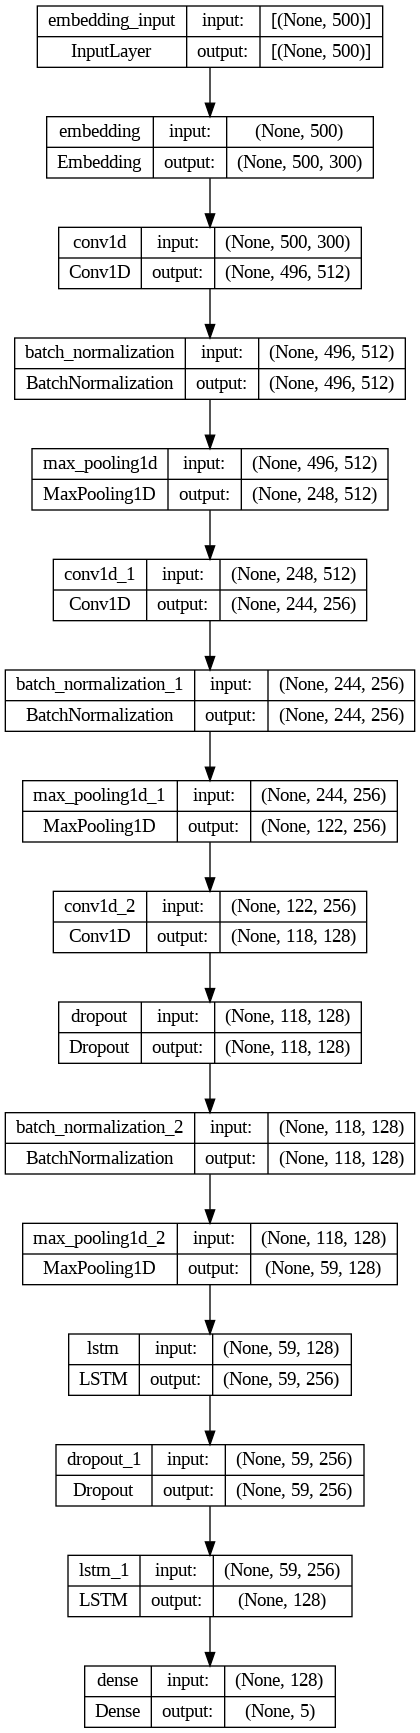

In [55]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [56]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          5832600   
                                                                 
 conv1d (Conv1D)             (None, 496, 512)          768512    
                                                                 
 batch_normalization (BatchN  (None, 496, 512)         2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 248, 512)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 244, 256)          655616    
                                                                 
 batch_normalization_1 (Batc  (None, 244, 256)         1

In [ ]:
batch_size = 256
epochs = 10

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

In [ ]:
# save the model
model.save('/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5')

In [76]:
# load the model
from keras.models import load_model
cnn_predictor = load_model('/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5')

In [77]:
# Example for Anger

import time

message = ['I am so angry at my neighbor for playing loud music late at night.']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = cnn_predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 1s 1s/step
Message: ['I am so angry at my neighbor for playing loud music late at night.']
predicted: anger (1.11 seconds)


In [78]:
# Example for Joy

import time

message = ['I feel over the moon about my promotion at work!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = cnn_predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 92ms/step
Message: ['I feel over the moon about my promotion at work!']
predicted: joy (0.27 seconds)


In [79]:
# Example for Fear

import time

message = ['I should go home, my parent might scold me.']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = cnn_predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 0s 217ms/step
Message: ['I should go home, my parent might scold me.']
predicted: fear (0.41 seconds)


In [83]:
!pip install modAL
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#Human-In-The-Loop Model using Active learning and without any Data Training

In [84]:
import gradio as gr
import numpy as np
import tensorflow as tf

# Load the saved model from .h5 file

from keras.models import load_model
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


model = load_model('/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5')

# Initialize the active learner Model
learner = ActiveLearner(
    estimator=model,
    query_strategy=uncertainty_sampling,
    X_training=X_train_pad, 
    y_training=y_train,
    bootstrap_init=False
)

752/752 [==============================] - 1736s 2s/step - loss: 1.1137 - accuracy: 0.5051


###Design UI for User Interaction using Gradio API

In [85]:

# Define the prediction function
def predict_sentiment(text):
  
    # Preprocess the input text
    text_clean = [' '.join(clean_text(text))]
    text_seq = tokenizer.texts_to_sequences(text_clean)
    text_pad = pad_sequences(text_seq, maxlen=max_seq_len)
    
    # Make the prediction
    prediction = model.predict(text_pad)[0]

    # Map the predicted value to the corresponding emotion
    emotions = ['joy', 'fear', 'anger', 'sadness', 'neutral']
    predicted_emotion = emotions[np.argmax(prediction)]

    # Get the index of the maximum value in the prediction probabilities array
    max_index = np.argmax(prediction)

    # Calculate the percentage value of the max value
    max_percentage = prediction[max_index] * 100

    return predicted_emotion, max_percentage

# Define the retrain function
def retrain_model(text, emotion):

    # Preprocess the input text
    text_clean = [' '.join(clean_text(text))]
    text_seq = tokenizer.texts_to_sequences(text_clean)
    text_pad = pad_sequences(text_seq, maxlen=max_seq_len)

    encoding = {
            'joy': 0,
            'fear': 1,
            'anger': 2,
            'sadness': 3,
            'neutral': 4
    }
    y = encoding[emotion]
    X = text_pad

    human_label_onehot_categorical = to_categorical(y, 5)
    y = human_label_onehot_categorical.reshape(1, -1) 
    learner.teach(X=X, y=y)

    # Save the model
    model.save("/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5")

    # Make a prediction with the updated model
    predicted_emotion, prediction = predict_sentiment(text)
    
    # Get the index of the maximum value in the prediction probabilities array
    max_index = np.argmax(prediction)

    # Calculate the percentage value of the max value
    max_percentage = prediction[max_index] * 100

    return predicted_emotion, max_percentage

# Define the inputs and outputs for the UI using Gradio API
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
          input_text = gr.Textbox(lines=5, label="Enter text to predict emotion")
          predicted_emotion = gr.Label(label="Predicted emotion")
          prediction_probs = gr.Label(label="Prediction probabilities")
          btn1 = gr.Button("Predict Emotion")
          btn1.click(predict_sentiment, inputs=[input_text], outputs=[predicted_emotion, prediction_probs])
        with gr.Column():
          retrain_emotion = gr.Dropdown(["sadness", "anger", "joy", "neutral", "fear"], label="Correct predicted emotion")
          retrain_output = gr.Label(label="Retrained model prediction")
          btn2 = gr.Button("Correct Model Prediction")
          btn2.click(retrain_model, inputs=[input_text, retrain_emotion], outputs=[retrain_output])

demo.launch(share=True, debug=True)



Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://db162f1fd4011f1734.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 1s 891ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://db162f1fd4011f1734.gradio.live


#Using Model Retraining

We used 'train_on_batch' module which allow us retrain our model using new user data.

In [ ]:
# load the model
from keras.models import load_model
cnn_predictor = load_model('/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5')

# Ask for human input
human_input = input("Please enter a text: ")

# Predict the emotion
human_input_seq = tokenizer.texts_to_sequences([human_input])
human_input_seq = pad_sequences(human_input_seq, maxlen=max_seq_len)
prediction = cnn_predictor.predict(human_input_seq)
emotion_labels = ['joy', 'fear', 'anger', 'sadness', 'neutral']
predicted_emotion = emotion_labels[np.argmax(prediction)]


# Print the predicted emotion
print("The predicted emotion is:", predicted_emotion)

# Retrain the model with human input
human_label = input("Please enter the correct emotion: ")

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
print(human_input_seq)

human_label_onehot = encoding[human_label]
print(human_label_onehot)

human_label_onehot_categorical = to_categorical(human_label_onehot, 5)
new_arr = human_label_onehot_categorical.reshape(1, -1) 
print(human_label_onehot_categorical)

cnn_predictor.train_on_batch(human_input_seq, new_arr)

# Predict again
predicted_again = cnn_predictor.predict(human_input_seq)
emotion_labels = ['joy', 'fear', 'anger', 'sadness', 'neutral']
predicted_emotion = emotion_labels[np.argmax(predicted_again)]

# Print the predicted emotion again
print("The predicted emotion is:", predicted_emotion)


In [ ]:
cnn_predictor.save('/content/drive/MyDrive/Final_Project/models/emotion_model_after_training.h5')

In [81]:
# Example for Angry

import time

message = ["I am so angry at my neighbor for playing loud music late at night."]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = cnn_predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 [==============================] - 1s 986ms/step
Message: ['I am so angry at my neighbor for playing loud music late at night.']
predicted: anger (1.04 seconds)
